In [1]:
import os, re, cv2
import numpy as np
from glob import glob
from tqdm import tqdm
from scipy import ndimage as ndi
from skimage import filters, morphology, img_as_ubyte, io, exposure, measure
from commons import (
    plot,
    split_mask_v1,
    binarize_image,
    auto_invert_image_mask,
    find_best_larger_cluster,
    find_bighest_cluster_area,
    rule_of_three_percent_pixels
)

In [8]:
def create_binary_mask(file, back, crop_neck=False):

    binary = ndi.median_filter(auto_invert_image_mask(file) ^ auto_invert_image_mask(back), size=5)
    mask1 = morphology.binary_opening(binary, morphology.disk(radius=5))
    mask = morphology.closing(mask1, morphology.disk(radius=5))
    
    if crop_neck:
        mask = split_mask_v1(mask)
    
    return find_best_larger_cluster(mask)

def get_image_area(image):
    clusters = measure.label(image, background=0)
    return find_bighest_cluster_area(clusters)
    
def fames_processing(destiny_images, broiler_index):
    
    folder_number, *_ = re.findall(r'\d+',broiler_index)
    try:
        os.mkdir(f'{destiny_images}/{folder_number}')
    except: pass
    
    path_frames = f'{broiler_index}/**/*.png'

    back_path, *_ = sorted(glob(path_frames))
    back = auto_invert_image_mask(io.imread(back_path))
    
    bodys = []

    for index, image in enumerate(tqdm(io.imread_collection(path_frames))):

        try:
            image_pixel = auto_invert_image_mask(binarize_image(image))

            if rule_of_three_percent_pixels(image_pixel)['true_pixels'] > 5:

                mask = create_binary_mask(auto_invert_image_mask(image), 
                                          back,
                                          crop_neck=True)
                
                bodys.append(mask)
        except: continue
        
    # default
    
    threshold = int(np.median(list(map(get_image_area, bodys))))
    
    for index, image in enumerate(tqdm(bodys)):
        if get_image_area(image) >= threshold:
            io.imsave(f'{destiny_images}/{folder_number}/{index}.png', img_as_ubyte(image))
  
    # for index, image in enumerate(tqdm(bodys)):
    #     io.imsave(f'{destiny_images}/{folder_number}/{index}.png', img_as_ubyte(image))

In [9]:
image = auto_invert_image_mask(io.imread("data_bin/140/imagens_depth/211.png"))
back = auto_invert_image_mask(io.imread("data_bin/140/imagens_depth/1.png"))

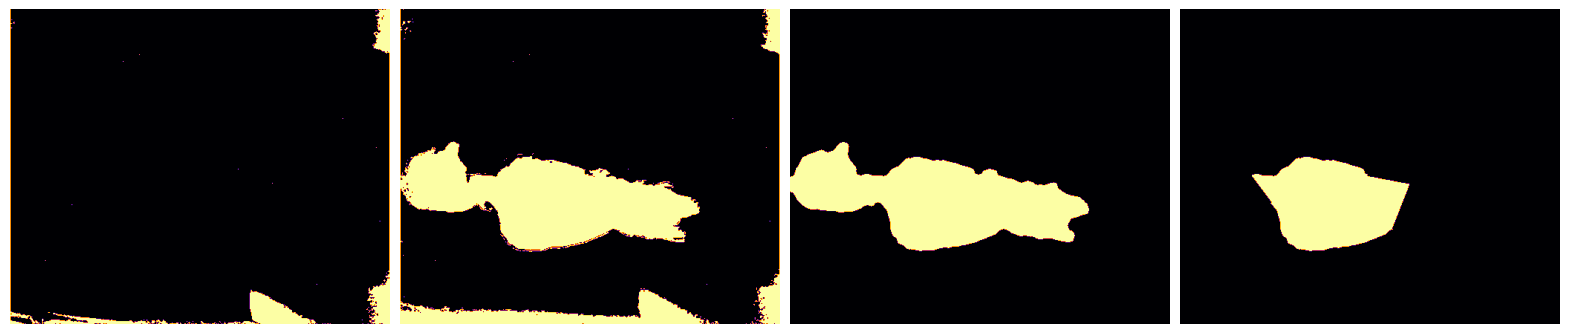

In [10]:
plot([back,
      image,
      create_binary_mask(image, back),
      create_binary_mask(image, back, True)], (1, 4))

In [11]:
try:
    destiny_images = 'outputs/selecteds_non_necks'
    os.mkdir(destiny_images)
except:
    print("Pasta já existe!")

Pasta já existe!


In [12]:
for broiler_index in glob('data_bin/*'):
    fames_processing(destiny_images, broiler_index)

100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 298.82it/s]
